In [ ]:
!pip install opencv-python-headless
!pip install torch torchvision
!pip install pandas
!pip install matplotlib
!pip install facenet-pytorch

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models import alexnet
from torchvision import datasets, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
from facenet_pytorch import MTCNN

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:

categories_df = pd.read_csv('/content/drive/MyDrive/ECE 50024/category.csv')


categories = categories_df['Category'].tolist()


category_to_index = {category: idx for idx, category in enumerate(categories)}




ground_truth_df = pd.read_csv('/content/drive/MyDrive/ECE 50024/train.csv')


ground_truth_df['File Name'] = ground_truth_df['File Name'].str.split('.').str[0]
ground_truth_map = dict(zip(ground_truth_df['File Name'], ground_truth_df['Category']))
print(ground_truth_map)


label_idx = [category_to_index[ground_truth_map[file_name]] for file_name in ground_truth_df['File Name']]


face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/ECE 50024/haarcascade_frontalface_default.xml')

mtcnn = MTCNN(keep_all=True)


def preprocess_image_facecascade(image_path):

    img = Image.open(image_path).convert('RGB')


    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.03, 5)

    if len(faces) > 0:
        (x, y, w, h) = faces[0]

        face = img.crop((x, y, x+w, y+h))

        face = transforms.Resize((224, 224))(face)

        face = transforms.ToTensor()(face)
        face = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(face)
        return face, True
    else:
        return None, False

def calculate_mean_std(dataset_path):
    image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
    channel_means = []
    channel_stds = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img = transform(img)

        mean = torch.mean(img, dim=(1, 2))
        std = torch.std(img, dim=(1, 2))

        channel_means.append(mean)
        channel_stds.append(std)


    channel_means_tensor = torch.stack(channel_means)
    channel_stds_tensor = torch.stack(channel_stds)


    all_channel_means = torch.mean(channel_means_tensor, dim=0)
    all_channel_stds = torch.mean(channel_stds_tensor, dim=0)

    return all_channel_means.numpy(), all_channel_stds.numpy()

def preprocess_image_facenet(image_path, mtcnn, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = Image.open(image_path).convert('RGB')
    img = transforms.Resize((224, 224))(img)
    img = transforms.ToTensor()(img) #/ 255.0

    img = transforms.Normalize(mean=mean, std=std)(img)
    return img


{'0': 'Audrey Tautou', '1': 'Adam Sandler', '2': 'Anna Paquin', '3': 'Ava Gardner', '4': 'Amy Adams', '5': 'Angelina Jolie', '6': 'Bill Paxton', '7': 'Alan Alda', '8': 'Abigail Breslin', '9': 'Alicia Vikander', '10': 'Albert Finney', '11': 'Aaron Judge', '12': 'Beyonce Knowles', '13': 'Beyonce Knowles', '14': 'Andrew Lincoln', '15': 'Armin Mueller-Stahl', '16': 'Andy Murray', '17': 'Amy Ryan', '18': 'Alan Arkin', '19': 'Adrien Brody', '20': 'Analeigh Tipton', '21': 'Amanda Bynes', '22': 'Anne Bancroft', '23': 'Amy Ryan', '24': 'Albert Brooks', '25': 'Barbra Streisand', '26': 'Amanda Peet', '27': 'bella thorne', '28': 'Amanda Peet', '29': 'Andy Samberg', '30': 'Annette Bening', '31': 'Anthony Perkins', '32': 'Barbra Streisand', '33': 'Anthony Perkins', '34': 'Adrien Brody', '35': 'Alice Eve', '36': 'Berenice Bejo', '37': 'Amanda Crew', '38': 'AnnaSophia Robb', '39': 'Anne Bancroft', '40': 'Ava Gardner', '41': 'Billy Bob Thornton', '42': 'Aaron Paul', '43': 'AnnaSophia Robb', '44': 'Alan

"\ndef preprocess_image_facenet(image_path, mtcnn):\n    img = Image.open(image_path).convert('RGB')\n    # Detect faces using MTCNN\n    boxes, probs = mtcnn.detect(img)\n    # Select the first detected face if any\n    if boxes is not None:\n        # Convert box coordinates to integers\n        boxes = boxes[0].astype(int)\n        # Extract face region\n        face = img.crop((boxes[0], boxes[1], boxes[2], boxes[3]))\n        # Resize face to (224, 224) for FaceNet\n        face = transforms.Resize((224, 224))(face)\n        # Convert to tensor and normalize\n        face = transforms.ToTensor()(face)\n        face = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(face)\n        # Generate face embedding using FaceNet\n        return face, True\n    else:\n        # Resize original image to (224, 224) for FaceNet\n        img = transforms.Resize((224, 224))(img)\n        # Convert to tensor and normalize\n        img = transforms.ToTensor()(img)\n      

In [ ]:

class CelebrityDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = preprocess_image_facenet(img_path, mtcnn, self.mean, self.std)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class CelebrityTensorDataset(Dataset):
    def __init__(self, tensor_paths, labels, transform=None):
        self.tensor_paths = tensor_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor_path = self.tensor_paths[idx]
        tensor = torch.load(tensor_path)  # Load the preprocessed tensor
        label = self.labels[idx]

        if self.transform:
            # Ensure tensor is in the expected format for transforms (C, H, W) with values in [0, 1]
            tensor = tensor.float()  # Assuming tensor is not already float
            # Apply transformations here
            tensor = self.transform(tensor)

        return tensor, label



"\nimport os\nfrom torch.utils.data import Dataset\nfrom PIL import Image\n\nclass CelebrityDataset(Dataset):\n    def __init__(self, image_paths, labels, transform=None, save_dir=None):\n        self.image_paths = image_paths\n        self.labels = labels\n        self.transform = transform\n        self.save_dir = save_dir\n\n        # Apply transformations and save cropped images\n        self.transformed_images = self.load_and_save_images()\n\n    def __len__(self):\n        return len(self.image_paths)\n\n    def load_and_save_images(self):\n        transformed_images = []\n        for img_path in self.image_paths:\n            img, extracted = preprocess_image_facenet(img_path, mtcnn)\n            if extracted:\n                if self.save_dir:\n                    # Create save directory if it doesn't exist\n                    os.makedirs(self.save_dir, exist_ok=True)\n                    # Define save path\n                    save_path = os.path.join(self.save_dir, os.path.b

In [ ]:
# Load your dataset and labels
from pathlib import Path
import glob
#mean, std = calculate_mean_std('/content/drive/MyDrive/ECE 50024/cropped_faces_outliers_excluded')
#print("mean", mean)
#print("std", std)
mean = [0.5957162,  0.4629442,  0.40489063]
std = [0.22739226, 0.20087235, 0.18877847]
image_paths = []
labels = []

celebrities_dir = '/content/drive/MyDrive/ECE 50024/cropped_large_tensors'

celebrities_dir_path = Path(celebrities_dir)
image_files = glob.glob(f"{celebrities_dir}/*.pt")  # Adjust the pattern as needed
print(len(image_files))
for image_file in image_files:
#for image_file in glob.iglob(f"{celebrities_dir}/*.pt"):
    image_name = Path(image_file).name.split('.')[0]
    #print(image_name)
    if image_name in ground_truth_map:
        label_str = ground_truth_map[image_name]
        label_idx = category_to_index[label_str]
        image_paths.append(image_file)
        labels.append(label_idx)
print(len(image_paths))

69579
69540


99
0
100


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:01<00:00, 177MB/s]


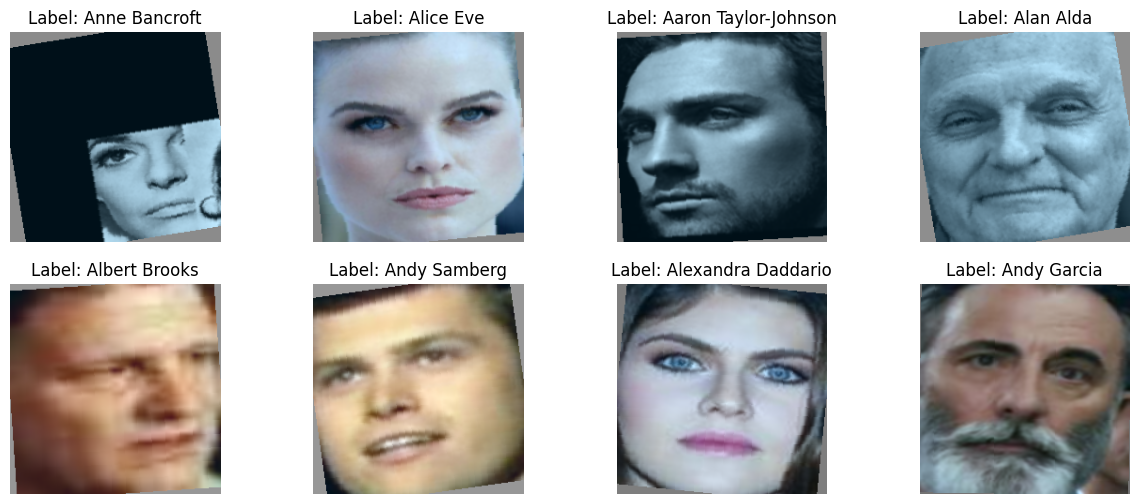

In [ ]:
import torchvision.utils as vutils
import torchvision.models as models

transform = transforms.Compose([
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(224, 224)),
])


train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
print(max(train_labels))
print(min(train_labels))

train_dataset = CelebrityTensorDataset(train_paths, train_labels, transform=transform)#, mean=mean, std=std)
val_dataset = CelebrityTensorDataset(val_paths, val_labels) #mean=mean, std=std)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

num_classes = len(categories)
print(num_classes)
#alexnet ~ 71% no checkpoints saved
#model = alexnet(pretrained=True)
#model.classifier[6] = nn.Linear(4096, num_classes)

#resnet50 # Validation Loss: 1.216256314425212, Validation Accuracy: 74.48950244463619% only 3 epochs need to train more
#resnet101 # 3 epochs: Validation Loss: 1.1996902329571328, Validation Accuracy: 76.47397181478286%
#model = models.resnet101(pretrained=True)

# Number of input features to the fully connected layer
#num_features = model.fc.in_features
# Replace the last layer with a new linear layer with the desired number of output features (your number of categories)
#model.fc = nn.Linear(num_features, num_classes)

#checkpoint = torch.load('/content/drive/MyDrive/ECE 50024/checkpoints/resnet101_checkpoint_epoch_3.pth.tar')

#model.load_state_dict(checkpoint)

model = models.convnext_small(pretrained=True) # Validation Loss: 1.0238178512094895, Validation Accuracy: 80.74489502444636% Epoch 3


num_ftrs = model.classifier[-1].in_features


model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

checkpoint = torch.load("/content/drive/MyDrive/ECE 50024/checkpoints/convnext_small_checkpoint_epoch_3.pth.tar")

model.load_state_dict(checkpoint)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

images, labels = next(iter(train_loader))


plt.figure(figsize=(15, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(vutils.make_grid(images[i], padding=2, normalize=True).permute(1, 2, 0))
    plt.title(f'Label: {categories[labels[i]]}')
    plt.axis('off')
plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/ECE 50024/checkpoints/convnext_small_outliers_checkpoint'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, epoch)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        filename = f"{self.path}_epoch_{epoch+1}.pth.tar"  # Append epoch number to filename
        torch.save(model.state_dict(), filename)
        self.val_loss_min = val_loss

In [ ]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=torch.device('cuda'), verbose=False):
    train_losses = []
    val_losses = []
    model.to(device)

    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        print('New Epoch')
        model.train()
        running_loss = 0.0
        train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=False)
        for i, (images, labels) in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            if verbose:
              if i % 100 == 0:
                  count = 0
                  _, predicted = torch.max(outputs, 1)
                  for j in range(len(labels)):
                      print(f'Batch {i}, Sample {j}: Predicted Label = {predicted[j].item()}, Correct Label = {labels[j].item()}')
                      count += 1
                      if count == 10:
                          break



        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
          val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Epoch {epoch+1}/{num_epochs} validation', leave=False)
          for i, (images, labels) in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {100 * correct / total}%')


        early_stopping(val_loss, model, epoch)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return train_losses, val_losses


In [ ]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

New Epoch


Epoch 1/20, Training Loss: 0.6980006173874477, Validation Loss: 0.9955691756583646, Validation Accuracy: 81.478285878631%
Validation loss decreased (inf --> 0.995569). Saving model ...
New Epoch


Epoch 2/20, Training Loss: 0.5174651522985436, Validation Loss: 1.0080322447884587, Validation Accuracy: 81.94564279551338%
EarlyStopping counter: 1 out of 5
New Epoch


KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()